<a href="https://colab.research.google.com/github/GiaKhangLuu/Sartorius-Cell-Instance-Segmentation/blob/master/Mosaic_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install opencv-python-headless==4.1.2.30
!pip install cellpose
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf
!pip install -q numpy==1.20.0
!pip install -q imgaug==0.3.0

     |████████████████████████████████| 69 kB 3.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.5 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
     |████████████████████████████████| 562 kB 10.2 MB/s 
     |████████████████████████████████| 25.4 MB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 86.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 8.5 MB/s 
     |████████████████

In [ ]:
!unzip ./drive/MyDrive/sartorius/dataset/fold_0.zip

Archive:  ./drive/MyDrive/sartorius/dataset/fold_0.zip
  inflating: train/0140b3c8f445_flows.tif  
  inflating: train/0140b3c8f445_img.tif  
  inflating: train/0140b3c8f445_masks.tif  
  inflating: train/01ae5a43a2ab_flows.tif  
  inflating: train/01ae5a43a2ab_img.tif  
  inflating: train/01ae5a43a2ab_masks.tif  
  inflating: train/026b3c2c4b32_flows.tif  
  inflating: train/026b3c2c4b32_img.tif  
  inflating: train/026b3c2c4b32_masks.tif  
  inflating: train/029e5b3b89c7_flows.tif  
  inflating: train/029e5b3b89c7_img.tif  
  inflating: train/029e5b3b89c7_masks.tif  
  inflating: train/0323e81d23d9_flows.tif  
  inflating: train/0323e81d23d9_img.tif  
  inflating: train/0323e81d23d9_masks.tif  
  inflating: train/03b27b381a5f_flows.tif  
  inflating: train/03b27b381a5f_img.tif  
  inflating: train/03b27b381a5f_masks.tif  
  inflating: train/042c17cd9143_flows.tif  
  inflating: train/042c17cd9143_img.tif  
  inflating: train/042c17cd9143_masks.tif  
  inflating: train/042dc0e561a4_flo

In [ ]:
!unzip ./drive/MyDrive/sartorius/dataset/sartorius-cell-instance-segmentation.zip -d ./sartorius-dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d00h00m_4.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: ./sartorius-dataset/LIVECell_dataset_202

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
import tifffile
import imageio
import glob
import shutil
from cellpose import models, io, plot
import glob
import shutil
import imgaug.augmenters as iaa
import imgaug as ia
import time
import cv2

In [ ]:
!mkdir './cellpose_dataset_train'
!mkdir './cellpose_dataset_val'
!mkdir './models'

In [ ]:
raw_df = pd.read_csv('./sartorius-dataset/train.csv')

# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [ ]:
def rles_to_mask_2_dim(encs, shape=SHAPE):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

def rles_to_mask_3_dim(encs, shape=SHAPE):
    # Image shape
    mask = np.full(shape=[len(encs), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, row in enumerate(encs):
        s = row.split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(encs), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [ ]:
# Get ids and cell type
sartorius_df = pd.read_csv('./sartorius-dataset/train.csv')
sartorius_df = sartorius_df.groupby('id').first()
ids_ct_df = sartorius_df['cell_type']

In [ ]:
train_img_ids = [f.split('/')[-1].replace('_img.tif', '') for f in 
                 glob.glob(os.path.join('./train', '*img.tif'))]

In [ ]:
train_ids_ct_df = ids_ct_df[ids_ct_df.index.isin(train_img_ids)]
astro_train_ids_ct_df = train_ids_ct_df.loc[train_ids_ct_df == 'astro']

In [ ]:
def load_image(image_id):
  img_file = os.path.join('./train', '{}_img.tif'.format(image_id))
  img = tifffile.imread(img_file)
  return img

def load_masks(image_id):
  encs = raw_df[raw_df['id'] == image_id].annotation.values
  return rles_to_mask_3_dim(encs)

In [ ]:
from matplotlib import image
def mosaic(image_id, image_inventory, SHAPE=(HEIGHT, WIDTH), seed=None):
        """
        Apply mosaice augmentation for the given image. The mechanism
        of this technique is merge 4 images then random crop to expected
        size.
        Args:
            image_id: The id of the image to load 
        Return:
            image: [height, width, 3]. 
            masks: [height, width, instance_count]. 
            class_ids: [instance_count].
        """        
        
        image_ids = np.random.choice(image_inventory, 3, replace=False)
        image_ids = np.append(image_ids, image_id)
        # Split images to stack
        stack_01_ids, stack_02_ids = image_ids[:2], image_ids[2:]
    
        # Read image and unpad (the image padded so we have to unpad back to the original size)
        stack_01_imgs = [load_image(image_id) for image_id in stack_01_ids]
        stack_02_imgs = [load_image(image_id) for image_id in stack_02_ids]
    
        # Horizontal stack images
        hstack_01 = np.hstack(stack_01_imgs)
        hstack_02 = np.hstack(stack_02_imgs)
    
        # Vertical stack
        mosaic_image = np.vstack((hstack_01, hstack_02))
            
        # Load mask and unpad (similar to image)
        stack_01_masks = [load_masks(image_id)
                          for image_id in stack_01_ids]
        stack_02_masks = [load_masks(image_id)
                          for image_id in stack_02_ids]
        
        #print(stack_01_masks[0].shape)
        #print(stack_01_masks[1].shape)
        #print(stack_02_masks[0].shape)
        #print(stack_02_masks[1].shape)

        mosaic_masks = merge_mask_to_mosaic(stack_01_masks, stack_02_masks, (HEIGHT, WIDTH))
        
        mosaic_image, mosaic_masks = random_crop(mosaic_image, mosaic_masks, 
                                                      (HEIGHT, WIDTH), seed)
        
        # After random cropping, the mosaic_masks may has all zero values
        # in several channels aka. do not contain instances, we must 
        # remove those channels. 
        mosaic_masks = remove_zero_channel_from_mask(mosaic_masks)
        
        return mosaic_image, mosaic_masks

In [ ]:
def merge_mask_to_mosaic(stack_01_masks, stack_02_masks, original_shape):
        """
        Merge 4 masks to apply mosaic technique
        Args:
            stack_01_masks: tuple(masks_01, masks_02). The first
                            2 upper images
            stack_02_masks: tuple(masks_03, masks_04). The last
                            2 lower images
            original_shape: shape of each mask before padding and merging
        Return:
            merge_masks: [HEIGHT * 2, WIDTH * 2, total_ins_count of 4 masks]. 
                        Mask after merging
        """
    
        # First 2 images locate at upper left and right of the mask,
        # last 2 images locate at lower left and right of the mask corresponding
        masks_01, masks_02 = stack_01_masks
        masks_03, masks_04 = stack_02_masks
    
        # Compute total depth aka. total number of instances from 4 masks
        num_upper_ins = masks_01.shape[-1] + masks_02.shape[-1]
        num_lower_ins = masks_03.shape[-1] + masks_04.shape[-1]
        num_ins = num_upper_ins + num_lower_ins
    
        # After concatenate, height and width of mask increase twice
        height, width = original_shape[0], original_shape[1]
        merge_masks = np.zeros((height*2, width*2, num_ins), dtype=np.uint8)
    
        # Upper
        merge_masks[:HEIGHT, :WIDTH, :masks_01.shape[-1]] = masks_01
        #print('[0:{}]'.format(masks_01.shape[-1]))
        merge_masks[:HEIGHT, WIDTH:, masks_01.shape[-1]:num_upper_ins] = masks_02
        #print('[{}:{}]'.format(masks_01.shape[-1], num_upper_ins))
    
        # Lower
        merge_masks[HEIGHT:, :WIDTH, 
                    num_upper_ins:(num_ins - masks_04.shape[-1])] = masks_03
        #print('[{}:{}]'.format(num_upper_ins, num_ins-masks_04.shape[-1]))
        merge_masks[HEIGHT:, WIDTH:, num_ins-masks_04.shape[-1]:] = masks_04
        #print('[{}:{}]'.format(num_ins-masks_04.shape[-1], merge_masks.shape[-1]))
    
        return merge_masks

In [ ]:
def random_crop(image, mask, crop_shape, seed=None):    
        """
        Randomly crop image and mask to expected shape.
        Args:
            image: [HEIGHT, WIDTH, CHANNELS]. Image to crop
            mask: [HEIGHT, WIDTH, INS_COUNT]. Mask to crop
            crop_shape: Expected size (height, width) to crop
        """
        if len(image.shape) < 3:
            image = np.expand_dims(image, axis=-1)
        num_image_channels = image.shape[-1]
        
        # Stack image and masks together to crop
        stacked_image = np.concatenate([image, mask.astype(image.dtype)], axis=-1)
        """
        # Randomly applied horizontal flip
        stacked_image = tf.image.random_flip_left_right(stacked_image)
        
        # Randomly cropped 
        crop_shape = np.concatenate([crop_shape, [stacked_image.shape[-1]]], axis=0)
        stacked_image = tf.image.random_crop(stacked_image, crop_shape, seed=seed)
        """
        
        aug_seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Crop(percent=0.25, keep_size=False)
        ])
        stacked_image = aug_seq.augment_image(stacked_image)
    
        image = stacked_image[..., :num_image_channels]
        mask = stacked_image[..., num_image_channels:]
    
        return image[..., 0], mask   

In [ ]:
def remove_zero_channel_from_mask(masks):
        """
        Remove zero channel (does not contain any instance) from mask
        after crop from mosaic
        Args: 
            masks: [HEIGHT, WIDTH, INS_COUNT].
        Return:
            new_masks: [HEIGHT, WIDTH, NEW_INS_COUNT].
        """
    
        # Swap depth and height channel from masks, in order to
        # sort the depth nonzero indices while using nonzero() func.
        masks_swap = np.swapaxes(masks, 0, 2)
        d, w, h = masks_swap.nonzero()
    
        # Count nonzero values for each channel
        d_pad = np.concatenate([[-1], d, [-1]])
        runs = np.where(d_pad[1:] != d_pad[:-1])[0]
        new_d = np.zeros(len(d), dtype=np.uint32)
    
        num_ins = len(runs) - 1
    
        for i, (start, end) in enumerate(zip(runs[:-1], runs[1:])):
               new_d[start: end] = i
        
        new_masks = np.zeros((*masks.shape[:-1], num_ins))
        new_masks[h, w, new_d] = 1
    
        return new_masks

In [ ]:
new_img, new_mask = mosaic(astro_train_ids_ct_df.index[0], list(astro_train_ids_ct_df.index))

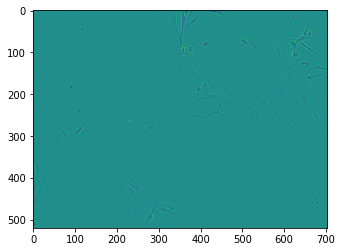

In [ ]:
plt.imshow(new_img)

In [ ]:
mask_enc = []

for i in range(new_mask.shape[-1]):
  ins_mask = new_mask[..., i].astype(np.uint8)
  mask_enc.append(rle_encode(ins_mask))

In [ ]:
print('Num ins of new mask: ', new_mask.shape[-1])

Num ins of new mask:  74


In [ ]:
new_masks_cp = rles_to_mask_2_dim(mask_enc, SHAPE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


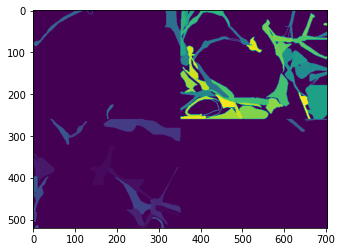

In [ ]:
plt.imshow(new_masks_cp)

In [ ]:
!mkdir mosaic_astro_data

In [ ]:
def prepare_mosaic_cort_images(image_id, image_inventory, index):
    img_template_file = './mosaic_astro_data/astro_{}_img.tif'
    mask_template_file = './mosaic_astro_data/astro_{}_masks.tif'

    new_img, new_masks = mosaic(image_id, image_inventory)

    mask_enc = []

    for i in range(new_masks.shape[-1]):
      ins_mask = new_masks[..., i].astype(np.uint8)
      mask_enc.append(rle_encode(ins_mask))

    new_masks_cp = rles_to_mask_2_dim(mask_enc, SHAPE)

    if new_masks.shape[-1] != new_masks_cp.max():
      print('Có lỗi rồi đại vương ơi!!!')

    tifffile.imsave(img_template_file.format(index), new_img)
    tifffile.imsave(mask_template_file.format(index), new_masks_cp)

In [ ]:
for i in tqdm(range(len(astro_train_ids_ct_df.index))):
  image_id = astro_train_ids_ct_df.index[i]
  prepare_mosaic_cort_images(image_id, list(astro_train_ids_ct_df.index), i)

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
100%|██████████| 103/103 [14:19<00:00,  8.34s/it]


In [ ]:
len(os.listdir('./mosaic_astro_data/'))

206

In [ ]:
!zip -r mosaic_astro_data.zip mosaic_astro_data